In [2]:
import re
import pickle
import pandas as pd
import numpy as np
from konlpy.tag import Okt, Mecab
from khaiii import KhaiiiAPi
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로드

In [5]:
data = pd.read_csv('../data/hate_speech_large.csv')
data.columns = ['comments', 'label']
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1


In [6]:
print("댓글 개수 :",len(data))

댓글 개수 : 190000


## 데이터 정제
* 긍정 댓글: 0
* 악성 댓글: 1

In [7]:
data['label'] = np.where(data['label'] == 0, 1, 0)

In [8]:
print('컬럼 별 고유 샘플의 수 : ({}, {})'.format(data['comments'].nunique(), data['label'].nunique())) # 중복 여부 확인
data.drop_duplicates(subset=["comments"], inplace=True) # 중복 제거
print('중복 제거 후 총 샘플의 수 :',len(data))

컬럼 별 고유 샘플의 수 : (187142, 2)
중복 제거 후 총 샘플의 수 : 187143


### 레이블 값의 분포

<AxesSubplot:>

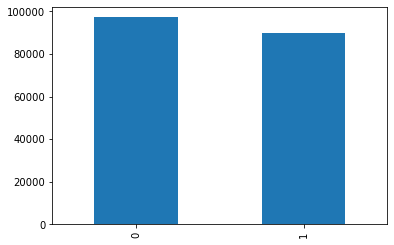

In [9]:
data['label'].value_counts().plot(kind = 'bar')

In [10]:
print(data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  97223
1      1  89920


### Null 값 제거

In [11]:
print(data.isnull().values.any(), end="\n\n") # Null 값 여부 확인
print(data.isnull().sum()) # Null 값의 갯수 출력

True

comments    1
label       0
dtype: int64


In [12]:
data.loc[data['comments'].isnull()]

,comments,label
7807,NaN,0


In [13]:
data = data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [14]:
print(len(data)) # Null 값 제거후 샘플의 수

187142


### 한글, 공백 제외 전처리

In [15]:
data['comments'] = data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,0
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,0
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,1
3,착한아이임당 용지 덮고,1
4,진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다 네티즌전문가 하나같이 영...,0


In [16]:
data['comments'] = data['comments'].str.strip()
data['comments'].replace('', np.nan, inplace=True)
print(data.isnull().sum())

comments    1021
label          0
dtype: int64


In [17]:
data = data.dropna(how = 'any')
print(len(data))

186121


### 학습 및 테스트 데이터 분리

In [18]:
train_data = data[:150000]
test_data = data[150000:]

train_data.to_csv("../data/train.csv", index=False)
test_data.to_csv("../data/test.csv", index=False)

## 형태소 분석

In [19]:
morphs_X_train = []
morphs_X_test = []

In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

### Khaiii

In [ ]:
api = KhaiiiApi()
X_train, X_test = [], []

for sentence in train_data["comments"]:
    temp = []
    for word in api.analyze(sentence): # 토큰화
        for morph in word.morphs:
            if morph.lex not in stopwords: # 불용어 제거
                temp.append(morph.lex)
    X_train.append(temp)  
    
for sentence in test_data["comments"]:
    temp = []
    for word in api.analyze(sentence): # 토큰화
        for morph in word.morphs:
            if morph.lex not in stopwords: # 불용어 제거
                temp.append(morph.lex)
    X_test.append(temp)
    
morphs_X_train.append(X_train)
morphs_X_test.append(X_test)

### Okt

In [ ]:
okt = Okt()
X_train, X_test = [], []

for sentence in train_data['comments']:
    temp = []
    temp = okt.morphs(sentence, stem=True) # 토큰화
    temp = [word for word in temp if not word in stopwords] # 불용어 제거
    X_train.append(temp)
    
for sentence in test_data['comments']:
    temp = []
    temp = okt.morphs(sentence, stem=True) # 토큰화
    temp = [word for word in temp if not word in stopwords] # 불용어 제거
    X_test.append(temp)
    
morphs_X_train.append(X_train)
morphs_X_test.append(X_test)

### Mecab

In [ ]:
mecab = Mecab()
X_train, X_test = [], []

for sentence in train_data['comments']:
    temp = []
    temp = mecab.morphs(sentence, stem=True) # 토큰화
    temp = [word for word in temp if not word in stopwords] # 불용어 제거
    X_train_mecab.append(temp)
    
for sentence in test_data['comments']:
    temp = []
    temp = mecab.morphs(sentence, stem=True) # 토큰화
    temp = [word for word in temp if not word in stopwords] # 불용어 제거
    X_test.append(temp)

morphs_X_train.append(X_train)
morphs_X_test.append(X_test)

## 정수 인코딩

### 단어 집합 생성

In [ ]:
tokens = []

for morph in morphs_X_train:
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(morph)
    tokens.append(tokenizer)

### 빈도 수가 낮은 단어 제거

In [ ]:
# 전체 단어의 수와, 등장 빈도가 threshhold 미만인 단어의 수를 리턴
def vocab_counts(data, threshold):
    rare_cnt, total_cnt = 0, len(data.word_index) 
    
    for key, value in data.word_counts.items():
        if value < threshold:
            rare_cnt = rare_cnt + 1
        
    return total_cnt, rare_cnt

In [ ]:
vocab_sizes = []

for i in range(len(morphs_X_train)):
    total_cnt, rare_cnt = vocab_counts(tokens[i], 3)
    vocab_size = total_cnt - rare_cnt + 2
    vocab_sizes.append(vocab_size)
    # 빈도수가 2이하인 단어들을 제거한 단어 집합을 이용하여 정수 인코딩
    tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
    tokenizer.fit_on_texts(morphs_X_train[i])
    morphs_X_train[i] = tokenizer.texts_to_sequences(morphs_X_train[i])
    morphs_X_test[i] = tokenizer.texts_to_sequences(morphs_X_test[i])

In [ ]:
print(len(morphs_X_train[1]), len(morphs_X_test[1]))

In [ ]:
morphs_y_train = [np.array(train_data['label']) for i in range(len(morphs_X_train))]

### 빈 샘플 제거

In [ ]:
for i in range(len(morphs_X_train)):
    # 빈도수가 2이하인 단어들로만 구성되었던 샘플들은 현재 비어 있기 때문에 해당 샘플들을 제거
    drop_morph = [index for index, sentence in enumerate(morphs_X_train[i]) if len(sentence) < 1]
    morphs_X_train[i] = np.delete(morphs_X_train[i], drop_morph, axis=0)
    morphs_y_train[i] = np.delete(morphs_y_train[i], drop_morph, axis=0)

In [ ]:
print(len(morphs_X_train[2]), len(morphs_y_train[2]))

### 패딩

In [ ]:
for i in range(len(morphs_X_train)):
    morphs_X_train[i] = pad_sequences(morphs_X_train[i], 45)
    morphs_X_test[i] = pad_sequences(morphs_X_test[i], 45)

## 전처리된 데이터 저장

In [ ]:
with open("../data/pickle/khaiii_X_train.pkl", "wb") as f:
    pickle.dump(morphs_X_train[0], f)

with open("../data/pickle/khaiii_y_train.pkl", "wb") as f:
    pickle.dump(morphs_y_train[0], f)
    
with open("../data/pickle/khaiii_X_test.pkl", "wb") as f:
    pickle.dump(morphs_X_test[0], f)
    
    
with open("../data/pickle/okt_train_X.pkl", "wb") as f:
    pickle.dump(morphs_X_train[1], f)

with open("../data/pickle/okt_train_y.pkl", "wb") as f:
    pickle.dump(morphs_y_train[1], f)
    
with open("../data/pickle/okt_test_X.pkl", "wb") as f:
    pickle.dump(morphs_X_test[1], f)


with open("../data/pickle/mecab_train_X.pkl", "wb") as f:
    pickle.dump(morphs_X_train[2], f)

with open("../data/pickle/mecab_train_y.pkl", "wb") as f:
    pickle.dump(morphs_y_train[2], f)
    
with open("../data/pickle/mecab_test_X.pkl", "wb") as f:
    pickle.dump(morphs_X_test[2], f)
    

with open("../data/pickle/vocab_sizes.pkl", "wb") as f:
    pickle.dump(vocab_sizes, f)